In [9]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
import pickle
from sklearn import preprocessing
from sklearn.svm import SVC as svc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import os

In [76]:
current_dir = os.getcwd()
data_file = os.path.join(current_dir, 'data', 'Healthcare-Diabetes.csv')
df = pd.read_csv(data_file)

In [77]:
df = df.drop(df.columns[0], axis = 1)
df = df.drop(df.columns[6], axis = 1)
df = df.drop(df.columns[3], axis = 1)

In [78]:
df

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,Age,Outcome
0,6,148,72,0,33.6,50,1
1,1,85,66,0,26.6,31,0
2,8,183,64,0,23.3,32,1
3,1,89,66,94,28.1,21,0
4,0,137,40,168,43.1,33,1
...,...,...,...,...,...,...,...
2763,2,75,64,55,29.7,33,0
2764,8,179,72,130,32.7,36,1
2765,6,85,78,0,31.2,42,0
2766,0,129,110,130,67.1,26,1


In [79]:
X, y = df.drop('Outcome', axis=1), df[['Outcome']]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [81]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_std = scaler.transform(X_train)
X_std = pd.DataFrame(X_std, columns = X_train.columns)
X_std_test = scaler.transform(X_test)
X_std_test = pd.DataFrame(X_std_test, columns = X_test.columns)

## RandomForest

In [82]:
rf = RandomForestClassifier(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 7, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [83]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 5, verbose=2, random_state=42, n_jobs = 5)

In [84]:
rf_random.fit(X_std, y_train.values.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=25, n_jobs=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

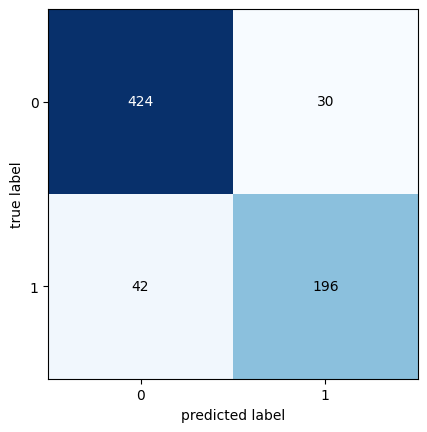

In [85]:
best_rf_random = rf_random.best_estimator_
pred = best_rf_random.predict(X_std_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred= pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat)
plt.show()

Accuracy Score of the classifier is: 0.8959537572254336
Precision Score of the classifier is: 0.8672566371681416
Recall Score of the classifier is: 0.8235294117647058
F1 Score of the classifier is: 0.8448275862068965
AUC for our classifier is: 0.9583904046199977


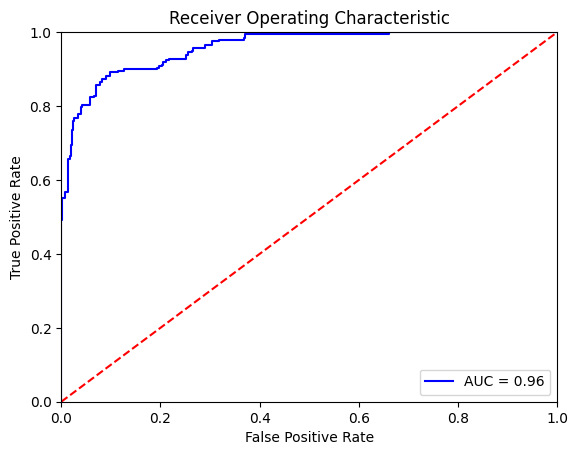

In [86]:
print(f"Accuracy Score of the classifier is: {accuracy_score(y_test, pred)}")
print(f"Precision Score of the classifier is: {precision_score(y_test, pred)}")
print(f"Recall Score of the classifier is: {recall_score(y_test, pred)}")
print(f"F1 Score of the classifier is: {f1_score(y_test, pred)}")
class_probabilities = best_rf_random.predict_proba(X_std_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [87]:
current_dir = os.getcwd()
model_file = os.path.join(current_dir, 'models', 'stage_2', 'model_rf.pkl')
pickle.dump(best_rf_random, open(model_file, 'wb'))
#best_rf_random = pickle.load(open('model_rf.pkl', 'rb'))

## XGBoost

In [88]:
max_depth = [int(x) for x in np.linspace(3, 7, num = 5)]
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.5, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
n_estimators = [100, 300, 500, 750, 1000]


random_grid = {'max_depth': max_depth,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'colsample_bylevel': colsample_bylevel,
               'n_estimators': n_estimators}
xgbc = xgb.XGBClassifier(seed = 42)
clf = RandomizedSearchCV(estimator=xgbc,
                         param_distributions=random_grid,
                         cv = 5,
                         scoring='accuracy',
                         n_iter=25,
                         verbose=2)
clf.fit(X_std, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=7, n_estimators=750, subsample=0.8999999999999999; total time=   1.3s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=7, n_estimators=750, subsample=0.8999999999999999; total time=   1.0s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=7, n_estimators=750, subsample=0.8999999999999999; total time=   0.9s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=7, n_estimators=750, subsample=0.8999999999999999; total time=   0.9s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=7, n_estimators=750, subsample=0.8999999999999999; total time=   0.9s
[CV] END colsample_byle

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=25,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 300, 500, 750,
                                                         1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='accuracy', verbose=2)

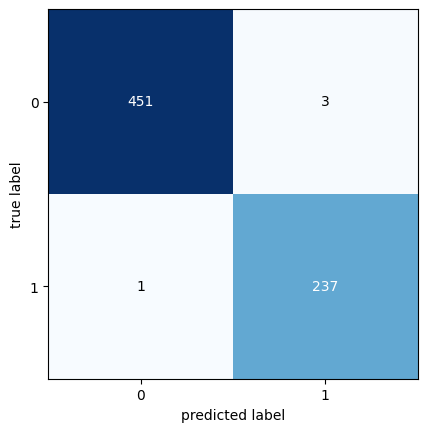

In [89]:
best_xgb_random = clf.best_estimator_
pred = best_xgb_random.predict(X_std_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred= pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat)
plt.show()

Accuracy Score of the classifier is: 0.9942196531791907
Precision Score of the classifier is: 0.9875
Recall Score of the classifier is: 0.9957983193277311
F1 Score of the classifier is: 0.9916317991631799
AUC for our classifier is: 0.9965664679968904


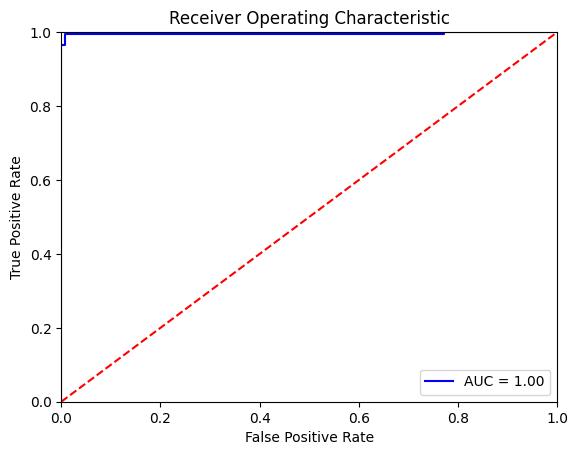

In [91]:
print(f"Accuracy Score of the classifier is: {accuracy_score(y_test, pred)}")
print(f"Precision Score of the classifier is: {precision_score(y_test, pred)}")
print(f"Recall Score of the classifier is: {recall_score(y_test, pred)}")
print(f"F1 Score of the classifier is: {f1_score(y_test, pred)}")
class_probabilities = best_xgb_random.predict_proba(X_std_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
current_dir = os.getcwd()
model_file = os.path.join(current_dir, 'models', 'stage_2', 'model_xgb.pkl')
pickle.dump(best_xgb_random, open(model_file, 'wb'))
#best_rf_random = pickle.load(open('model_rf.pkl', 'rb'))

## SVM

In [93]:
C = np.arange(2, 10, 2)
kernel = ["linear", "poly", "rbf", "sigmoid"]
gamma = np.arange(0.1, 1, 0.2)
random_grid = {'C': C,
               'gamma': gamma,
               'kernel': kernel}
svm = svc(random_state = 42, probability = True)
svm_random = RandomizedSearchCV(svm, param_distributions = random_grid, n_iter = 20, cv = 5, scoring = 'accuracy', verbose = 2) 
svm_random.fit(X_std, y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ......C=8, gamma=0.9000000000000001, kernel=sigmoid; total time=   0.4s
[CV] END ......C=8, gamma=0.9000000000000001, kernel=sigmoid; total time=   0.4s
[CV] END ......C=8, gamma=0.9000000000000001, kernel=sigmoid; total time=   0.4s
[CV] END ......C=8, gamma=0.9000000000000001, kernel=sigmoid; total time=   0.4s
[CV] END ......C=8, gamma=0.9000000000000001, kernel=sigmoid; total time=   0.4s
[CV] END ........................C=6, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ........................C=6, gamma=0.1, kernel=poly; total time=   0.4s
[CV] END ........................C=6, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ........................C=6, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ........................C=6, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ......................C=6, gamma=0.1, kernel=linear; total time=   0.8s
[CV] END ......................C=6, gamma=0.1, 

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=20,
                   param_distributions={'C': array([2, 4, 6, 8]),
                                        'gamma': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='accuracy', verbose=2)

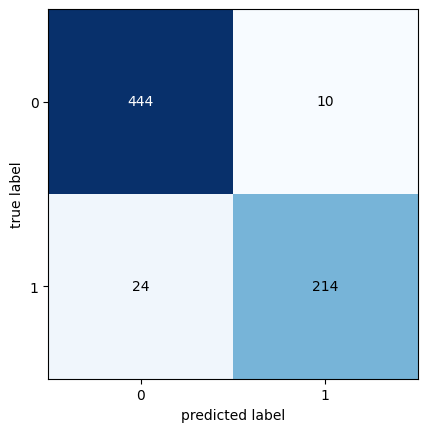

In [94]:
best_svm_random = svm_random.best_estimator_
pred = best_svm_random.predict(X_std_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred= pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat)
plt.show()

Accuracy Score of the classifier is: 0.9508670520231214
Precision Score of the classifier is: 0.9553571428571429
Recall Score of the classifier is: 0.8991596638655462
F1 Score of the classifier is: 0.9264069264069265
AUC for our classifier is: 0.9832025321141673


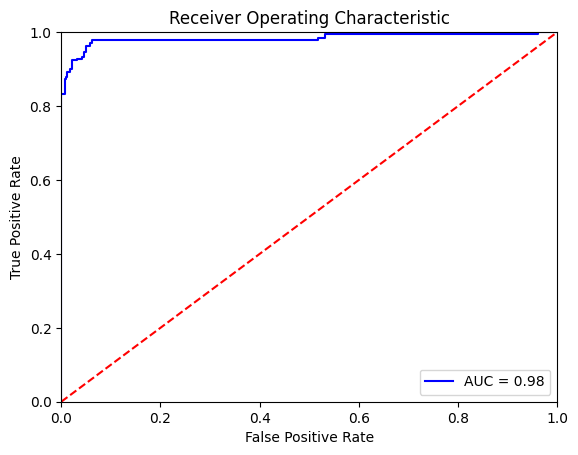

In [96]:
print(f"Accuracy Score of the classifier is: {accuracy_score(y_test, pred)}")
print(f"Precision Score of the classifier is: {precision_score(y_test, pred)}")
print(f"Recall Score of the classifier is: {recall_score(y_test, pred)}")
print(f"F1 Score of the classifier is: {f1_score(y_test, pred)}")
class_probabilities = best_svm_random.predict_proba(X_std_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
current_dir = os.getcwd()
model_file = os.path.join(current_dir, 'models', 'stage_2', 'model_svm.pkl')
pickle.dump(best_svm_random, open(model_file, 'wb'))

## KNN

In [97]:
estimator_KNN = KNeighborsClassifier(algorithm='auto')

n_neighbors = np.arange(1, 10, 1)
leaf_size = np.arange(20, 40, 1)
p = [1,2]
weights = ["uniform", "distance"]
metric = ["minkowski", "chebyshev"]

parameters_KNN = {
    'n_neighbors': n_neighbors,
    'leaf_size': leaf_size,
    'p': p,
    'weights': weights,
    'metric': metric}
                   
KNN = RandomizedSearchCV(
    estimator=estimator_KNN,
    param_distributions = parameters_KNN,
    scoring = 'accuracy',
    cv = 5,
    verbose=2
)

KNN.fit(X_std, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END leaf_size=38, metric=chebyshev, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=38, metric=chebyshev, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=38, metric=chebyshev, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=38, metric=chebyshev, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=38, metric=chebyshev, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=37, metric=minkowski, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=37, metric=minkowski, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=37, metric=minkowski, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=37, metric=minkowski, n_neighbors=4, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=37, metric=minkowski, n_neighbors=4, p=1, 

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39]),
                                        'metric': ['minkowski', 'chebyshev'],
                                        'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy', verbose=2)

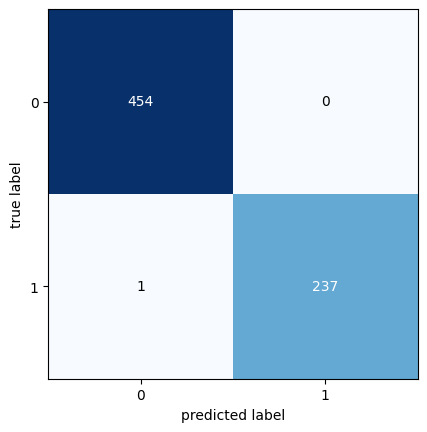

In [98]:
best_knn_random = KNN.best_estimator_
pred = best_knn_random.predict(X_std_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred= pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat)
plt.show()

## Decision Tree

In [108]:
max_depth = np.arange(2, 6, 1)
max_features = [int(x) for x in np.linspace(1, 6, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(1, 6, num = 5)]
criterion = ["gini", "entropy"]

random_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_leaf": min_samples_leaf,
              "criterion": criterion}

tree = DecisionTreeClassifier(random_state = 42)

tree_random = RandomizedSearchCV(estimator = tree,
                                   param_distributions = random_grid,
                                   n_iter = 25,
                                   scoring = 'accuracy',
                                   verbose = 2, 
                                   cv = 5,
                                   random_state = 42,
                                  )

tree_random.fit(X_std, y_train.values.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END criterion=gini, max_depth=5, max_features=6, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=6, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=6, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=6, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=6, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=4, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=4, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=4, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=4, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=4, min_samples_leaf=1; total time=   0.0s
[CV] END

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=25,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 3, 4, 5]),
                                        'max_features': [1, 2, 3, 4, 6],
                                        'min_samples_leaf': [1, 2, 3, 4, 6]},
                   random_state=42, scoring='accuracy', verbose=2)

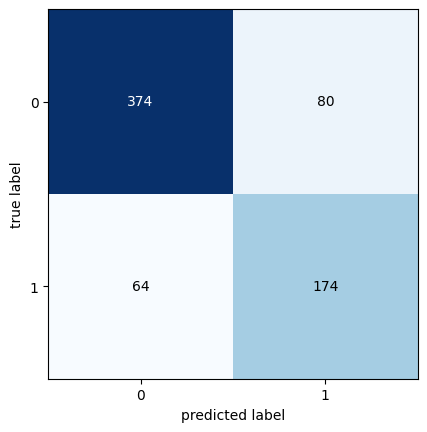

In [109]:
best_tree_random = tree_random.best_estimator_
pred = best_tree_random.predict(X_std_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred = pred)
fig, ax = plot_confusion_matrix(conf_mat = conf_mat)
plt.show()

Accuracy Score of the classifier is: 0.791907514450867
Precision Score of the classifier is: 0.6850393700787402
Recall Score of the classifier is: 0.7310924369747899
F1 Score of the classifier is: 0.7073170731707317
AUC for our classifier is: 0.860011846148151


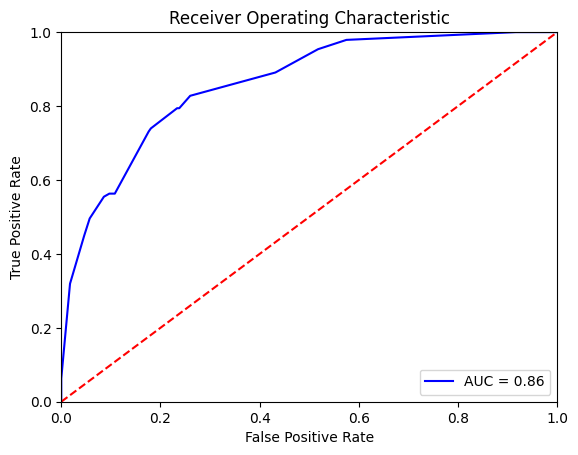

In [110]:
print(f"Accuracy Score of the classifier is: {accuracy_score(y_test, pred)}")
print(f"Precision Score of the classifier is: {precision_score(y_test, pred)}")
print(f"Recall Score of the classifier is: {recall_score(y_test, pred)}")
print(f"F1 Score of the classifier is: {f1_score(y_test, pred)}")
class_probabilities = best_tree_random.predict_proba(X_std_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()